#Joseph Mattouk
###### link to collab: https://colab.research.google.com/drive/1-X0Z6QrFncWnZSBF-VpqAHFhm7kbcfDd?usp=sharing

# Trees - Modelling

![image.png](attachment:image.png)

## PROBLEM: With given dataset, predict the probability of the payment within 90 days!

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_9-Trees.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


pd.set_option('display.max_colwidth', None)

con = sqlite3.connect('session_9-Trees.db')

df_metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
df_metadata

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup here in ******! Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better.

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach.

### Some tips on the task

There is no end to seeking the perfection, and countless ways to approach this task. However, try not to approach this like a competition to crank out the highest possible accuracy metrics. What matters is the sequence and thought process - show this in illustrations and comments! Even if certain things might take too long to implement in a code, but you have a good idea where to go with this - write down your ideas! This is what matters.

Good luck!

# Solution

### First look at the data

In [ ]:
df = pd.read_sql_query('SELECT * FROM dataset;', con)
df.head()

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


### Implement an Exploratory Data Analysis (EDA) and draw some practical and business conclusions

In [ ]:
# Check the number of rows and columns
df.shape

(30000, 19)

In [ ]:
# Check the data types
df.dtypes

case_id      int64
keydate     object
ct090      float64
ap090      float64
c0001      float64
c0039       object
c0044       object
d0031      float64
b0007      float64
d0009      float64
c0031      float64
a8404      float64
c0019      float64
d0027      float64
c9008      float64
d2112      float64
d0012       object
d1205      float64
c0015      float64
dtype: object

#### Lets make the keydate as a date time stamp and not a string, And we can also see that c0044 and d0012 are numbers but have an str data type, we will have to fix that


In [ ]:

df['keydate'] = pd.to_datetime(df['keydate'], format='%Y-%m-%d %H:%M:%S')
df['c0044'] = df['c0044'].astype(int)
df['d0012'] = df['d0012'].astype(int)

I will want to use the keydate in the machine learning model, so we will have to change the data type in order to be able to put it in the model

In [ ]:
df['year'] = df['keydate'].dt.year
df['month'] = df['keydate'].dt.month
df['day'] = df['keydate'].dt.day
df.head()

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,...,c0019,d0027,c9008,d2112,d0012,d1205,c0015,year,month,day
0,1,2017-08-12,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,...,98.0,0.0,49.0,0.0,1,NaN,222.69,2017,8,12
1,2,2017-02-03,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,...,109.0,2.0,51.0,0.0,2,1.0,212.72,2017,2,3
2,3,2017-02-17,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,...,748.0,0.0,48.0,NaN,3,NaN,56.84,2017,2,17
3,4,2017-09-18,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,...,8.0,0.0,27.0,NaN,4,NaN,463.15,2017,9,18
4,5,2017-07-22,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,...,324.0,0.0,40.0,0.0,1,NaN,146.09,2017,7,22


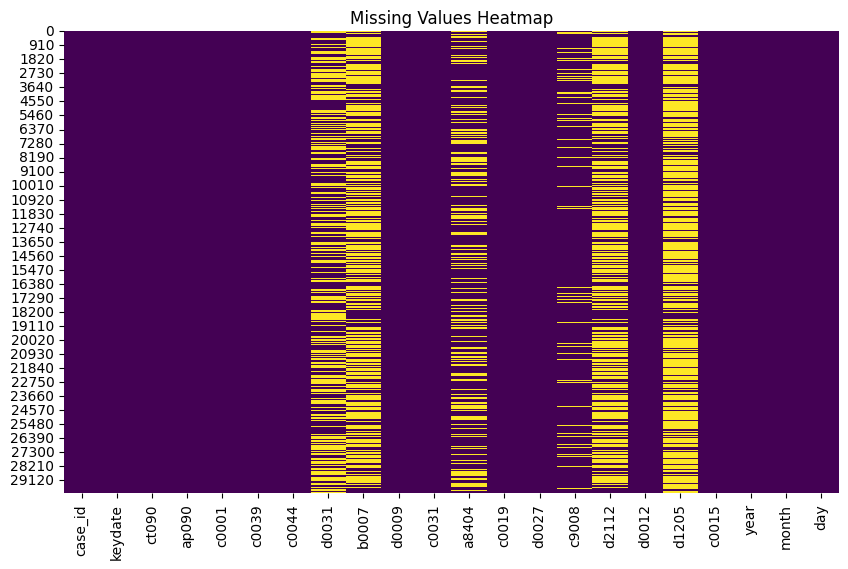

In [ ]:
# Create a heatmap for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

# Set plot title
plt.title('Missing Values Heatmap')

# Show the plot
plt.show()


In [ ]:
# Check for missing values
df.isnull().sum()

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
year           0
month          0
day            0
dtype: int64

In [ ]:
# Check in percentage how many rows in d1205 are missing
d12 = df['d1205'].isnull().sum() / df.shape[0] * 100
b0007 = df['b0007'].isnull().sum() / df.shape[0] * 100
d003 = df['d0031'].isnull().sum() / df.shape[0] * 100
d2112 = df['d2112'].isnull().sum() / df.shape[0] * 100
d8404 = df['a8404'].isnull().sum() / df.shape[0] * 100
print(f'd1205: {d12:.2f}%')
print(f'd0031: {d003:.2f}%')
print(f'b0007: {b0007:.2f}%')
print(f'd2112: {d2112:.2f}%')
print(f'a8404: {d8404:.2f}%')

d1205: 70.79%
d0031: 42.10%
b0007: 56.42%
d2112: 56.51%
a8404: 34.67%


### Work with missing values and draw some conclusions

#### Here we can see that there are values missing between 40% and 70% of some data in columns are missing. I will have to drop some of the columns that have more than 50% missing values. Because i cannot create new data in a column that has more than 50% missing values


In [ ]:
df.drop('d1205', axis=1, inplace=True)
df.drop('b0007', axis=1, inplace=True)
df.drop('d2112', axis=1, inplace=True)

##### I wanted to check the data type of a8404 to see how to manipukate the missing values as i thought it was a string because RatioOfCustomersAtAddressWithSuccessfullyClose this is what it said it was. Seen that we have around 70% of the data, i can use the mean to fill in the data

In [ ]:
## Replace NaN values in a8404 with the mean because there is only 34% missing values, we can afford to keep the column
df['a8404'].fillna(df['a8404'].mean(), inplace=True)
df.head()

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,d0009,c0031,a8404,c0019,d0027,c9008,d0012,c0015,year,month,day
0,1,2017-08-12,0.0,0.0,221.68,K6622,1,2.0,238.38,2.0,0.283395,98.0,0.0,49.0,1,222.69,2017,8,12
1,2,2017-02-03,0.0,0.0,151.36,K6512,2,NaN,0.00,5.0,0.283395,109.0,2.0,51.0,2,212.72,2017,2,3
2,3,2017-02-17,0.0,0.0,48.84,K6512,3,1.0,0.00,2.0,0.000000,748.0,0.0,48.0,3,56.84,2017,2,17
3,4,2017-09-18,0.0,0.0,413.15,K6622,4,NaN,54.14,3.0,1.000000,8.0,0.0,27.0,4,463.15,2017,9,18
4,5,2017-07-22,0.0,0.0,125.83,K6512,5,2.0,83.00,6.0,0.283395,324.0,0.0,40.0,1,146.09,2017,7,22


In [ ]:
# Check for missing values
df.isnull().sum()

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
d0009          0
c0031          0
a8404          0
c0019          0
d0027          0
c9008       2984
d0012          0
c0015          0
year           0
month          0
day            0
dtype: int64

##### We know that c9008 is the age of the person so it would make more sense to input the mean of the age as the missing value

In [ ]:
# Replace c9008 by the mean
df['c9008'].fillna(df['c9008'].mean(), inplace=True)
df.isnull().sum()

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
d0009          0
c0031          0
a8404          0
c0019          0
d0027          0
c9008          0
d0012          0
c0015          0
year           0
month          0
day            0
dtype: int64

Imputing missing values ensures a more complete dataset for meaningful exploratory analysis, preventing skewed insights and preserving overall data distribution.
OriginalCapitalOfCaseInvoices influences the financial aspect, while RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months and RatioOfCustomersAtAddressWithUnsuccessfullyClosedCasesLast36Months measure customer success, providing insights into potential financial impacts of successful and unsuccessful case closures.

In [ ]:
# Select the columns 'd0031' and 'c0001' and convert them to a numpy array
columns_to_impute = ['d0031', 'c0001']
X = df[columns_to_impute].values

# Initialize the IterativeImputer with the EM algorithm
imputer = IterativeImputer(max_iter=10, random_state=0)

# Perform imputation
X_imputed = imputer.fit_transform(X)

# Replace the NaN values in the original DataFrame with the imputed values
df[columns_to_impute] = X_imputed


In [ ]:
df.dtypes

case_id             int64
keydate    datetime64[ns]
ct090             float64
ap090             float64
c0001             float64
c0039              object
c0044               int64
d0031             float64
d0009             float64
c0031             float64
a8404             float64
c0019             float64
d0027             float64
c9008             float64
d0012               int64
c0015             float64
year                int64
month               int64
day                 int64
dtype: object

In [ ]:
le = LabelEncoder()
df['c0039'] = le.fit_transform(df['c0039'])
df.head()


,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,d0009,c0031,a8404,c0019,d0027,c9008,d0012,c0015,year,month,day
0,1,2017-08-12,0.0,0.0,221.68,7,1,2.000000,238.38,2.0,0.283395,98.0,0.0,49.0,1,222.69,2017,8,12
1,2,2017-02-03,0.0,0.0,151.36,5,2,1.630519,0.00,5.0,0.283395,109.0,2.0,51.0,2,212.72,2017,2,3
2,3,2017-02-17,0.0,0.0,48.84,5,3,1.000000,0.00,2.0,0.000000,748.0,0.0,48.0,3,56.84,2017,2,17
3,4,2017-09-18,0.0,0.0,413.15,7,4,1.632972,54.14,3.0,1.000000,8.0,0.0,27.0,4,463.15,2017,9,18
4,5,2017-07-22,0.0,0.0,125.83,5,5,2.000000,83.00,6.0,0.283395,324.0,0.0,40.0,1,146.09,2017,7,22


<ipython-input-213-e47a9edcde45>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)


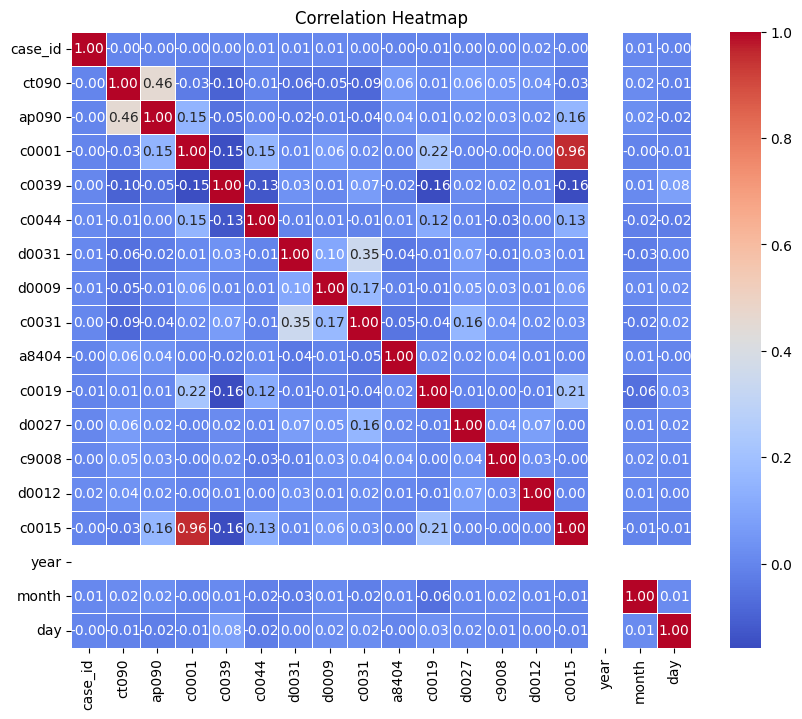

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

Here we can see that the case is pretty useless for the data since there is basically no corrolation what so ever so we can drop it

In [ ]:
df = df.drop(['case_id'], axis=1)

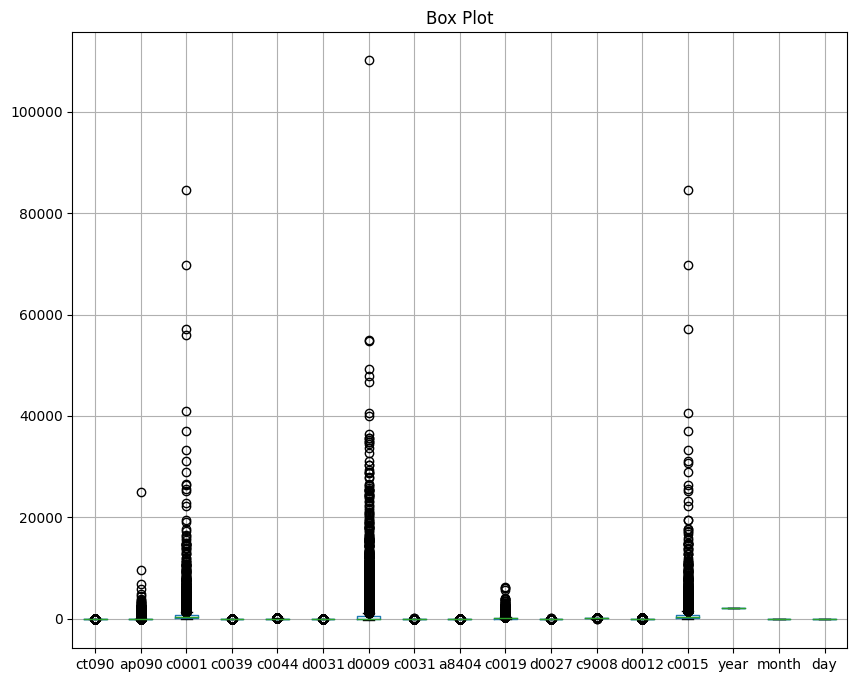

In [ ]:
plt.figure(figsize=(10, 8))
df.boxplot()
plt.title('Box Plot')
plt.show()

Explaining the outliers and why I think they should be kept.
Firstly we can see that there are not akot of outliers, so no need to cut them all off.
- c0001; is the which is the original capital asked for so for this an outlier on the higher side could indicate an individual or case where the requested loan amount is exceptionally large compared to the majority of loan applications. This might be due to specific circumstances, financial needs, or unique business requirements.
- d0009; for the amount of open cases, a customer with a remarkably high number of open cases might be experiencing repeated service or product issues, suggesting potential dissatisfaction or recurring problems.
- c0015, amount of open cases a high number of open cases might indicate a backlog or difficulty in resolving customer issues promptly. It could be a signal of service inefficiencies or increased demand for support.

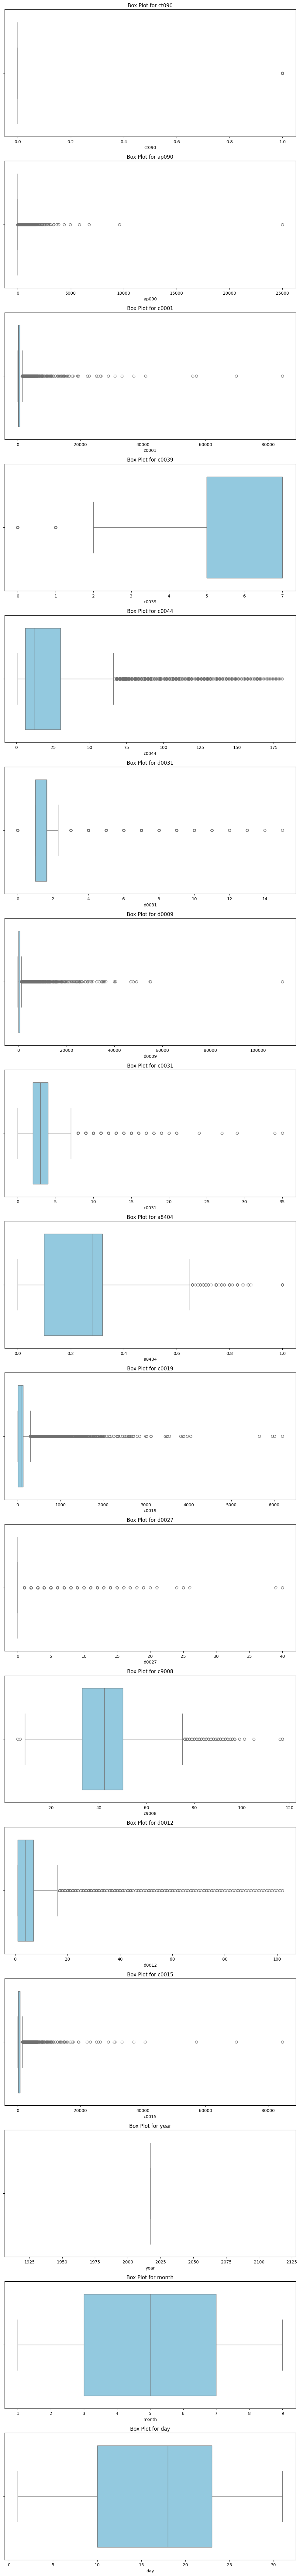

In [ ]:

# Selecting only numeric columns for outlier detection
numeric_columns = df.select_dtypes(include='number').columns

# Setting up subplots
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(10, 5 * len(numeric_columns)))

# Creating box plots for each numeric column
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot for {col}')

# Adjusting layout
plt.tight_layout()
plt.show()


#### After removing all the outliers and re-running the model, the accuracy did not change significantly. This is expected because outliers in certain variables, like c0044 (names), may carry meaningful information and are not detrimental to the model. The minimal change in accuracy is due to the nature of these outliers, which are not considered outliers in the context of the data. Careful consideration of the impact of outlier removal on model performance is crucial, taking into account the nature of each variable and the overall data context.

### In our dataset, both 'c0019', indicating the age of debt, and 'd0012', the last original closing code of a customer, display significant outliers, suggesting variations that may not mirror typical behavior. Similarly, outliers in 'd0027' (NumberOfCustomerIncomingCallDatesTee) highlight atypical frequencies of customer calls. These anomalies can distort analysis and model performance, underscoring the importance of removing such outliers to ensure analyses and models accurately represent general trends and behaviors, enhancing predictive accuracy and the reliability of insights on customer engagement and activity patterns.

In [ ]:
# Remove outliers beyond the 0.75 quantile for c0019
Q3_c0019 = df['c0019'].quantile(0.75)
IQR_c0019 = Q3_c0019 - df['c0019'].quantile(0.25)
upper_bound_c0019 = Q3_c0019 + 1.5 * IQR_c0019

df_no_outliers_c0019 = df[df['c0019'] <= upper_bound_c0019]

# Remove outliers beyond the 0.75 quantile for d0012 in the filtered DataFrame
Q3_d0012 = df_no_outliers_c0019['d0012'].quantile(0.75)
IQR_d0012 = Q3_d0012 - df_no_outliers_c0019['d0012'].quantile(0.25)
upper_bound_d0012 = Q3_d0012 + 1.5 * IQR_d0012

df_no_outliers_d0012 = df_no_outliers_c0019[df_no_outliers_c0019['d0012'] <= upper_bound_d0012]

# Remove outliers beyond the 0.75 quantile for d0027 in the further filtered DataFrame
Q3_d0027 = df_no_outliers_d0012['d0027'].quantile(0.75)
IQR_d0027 = Q3_d0027 - df_no_outliers_d0012['d0027'].quantile(0.25)
upper_bound_d0027 = Q3_d0027 + 1.5 * IQR_d0027

df = df_no_outliers_d0012[df_no_outliers_d0012['d0027'] <= upper_bound_d0027]


### Feature engineering

### I will explain why i chose these in Features importance; in the next step

In [ ]:
# Creating a new column for the average payment amount per case
df['AveragePaymentAmountPerCase'] = df['c0001'] / (df['d0009'] + 1)

# Creating how many times a clients name came up
df['ClientNameFrequency'] = df.groupby('c0044')['c0044'].transform('count')

# Creating a new column of the frequency to check how many times an industry code is mentioned
df['IndustryCodeFrequency'] = df.groupby('c0039')['c0039'].transform('count')

<ipython-input-218-136ab5cdc620>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AveragePaymentAmountPerCase'] = df['c0001'] / (df['d0009'] + 1)
<ipython-input-218-136ab5cdc620>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ClientNameFrequency'] = df.groupby('c0044')['c0044'].transform('count')
<ipython-input-218-136ab5cdc620>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

## Normalize the dataset

##### Normalization is crucial for various reasons. It enhances algorithm convergence, especially for gradient descent-based methods, and ensures accurate distance calculations in algorithms like K-nearest neighbors and k-means clustering. Moreover, normalization prevents one feature from dominating the outcome, promotes regularization assumptions, and addresses numerical stability issues. Overall, it significantly improves model performance and stability.

### I will have to drop the keydate before i normalize the data as it cannot normalise datetime

In [ ]:

df.drop('keydate', axis=1, inplace=True)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
normalized_data = scaler.fit_transform(df)

# Convert the normalized array back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)
df.head()

<ipython-input-219-435357163785>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('keydate', axis=1, inplace=True)


,ct090,ap090,c0001,c0039,c0044,d0031,d0009,c0031,a8404,c0019,d0027,c9008,d0012,c0015,year,month,day,AveragePaymentAmountPerCase,ClientNameFrequency,IndustryCodeFrequency
0,0.0,0.0,0.006660,1.000000,0.000000,0.133333,0.010114,0.057143,0.283395,0.319865,0.0,0.381818,0.0,0.006295,0.0,0.875,0.366667,0.000232,0.031705,0.603685
1,0.0,0.0,0.012413,1.000000,0.016854,0.108865,0.006771,0.085714,1.000000,0.016835,0.0,0.181818,0.2,0.013522,0.0,1.000,0.566667,0.000479,0.267781,0.603685
2,0.0,0.0,0.001706,0.714286,0.028090,0.066667,0.005788,0.085714,0.283395,0.003367,0.0,0.363636,0.0,0.003141,0.0,0.500,0.400000,0.002337,1.000000,1.000000
3,0.0,0.0,0.020059,1.000000,0.033708,0.109024,0.008457,0.114286,0.283395,0.033670,0.0,0.254545,0.2,0.021172,0.0,0.125,0.733333,0.000367,0.267352,0.603685
4,0.0,0.0,0.002319,1.000000,0.039326,0.133333,0.008557,0.028571,0.360000,0.205387,0.0,0.363636,0.0,0.002842,0.0,1.000,0.033333,0.000216,0.083119,0.603685


### Features importance

##AveragePaymentAmountPerCase:
###Explanation: This feature represents the average payment amount per case for each customer. It provides insights into the typical payment behavior of a customer relative to the number of open cases.

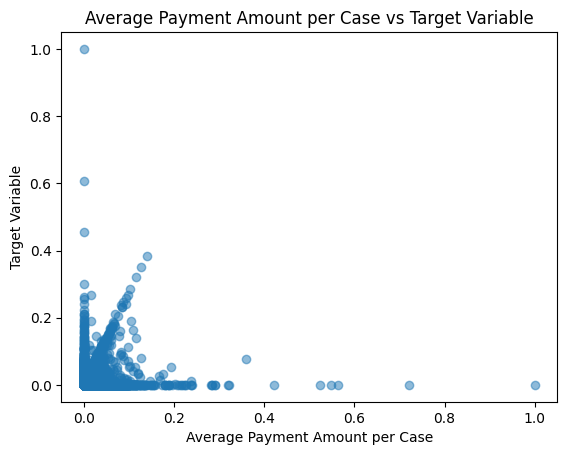

In [ ]:
plt.scatter(df['AveragePaymentAmountPerCase'], df['ap090'], alpha=0.5)
plt.title('Average Payment Amount per Case vs Target Variable')
plt.xlabel('Average Payment Amount per Case')
plt.ylabel('Target Variable')
plt.show()


##### This graph suggests a possible correlation between the average payment amount per case and the target variable, indicating that as the payment amount varies, so does the target variable.

### ClientNameFrequency:
#### Explanation: This feature encodes the frequency of each client name. It provides information on how common or rare each client name is in the dataset.

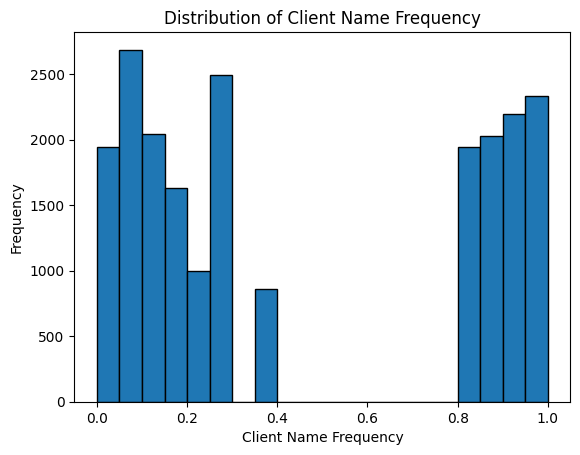

In [ ]:
plt.hist(df['ClientNameFrequency'], bins=20, edgecolor='black')
plt.title('Distribution of Client Name Frequency')
plt.xlabel('Client Name Frequency')
plt.ylabel('Frequency')
plt.show()


#### This could be useful for identifying key clients or for creating features that segment clients based on case frequency, which could be predictive of other behaviors or outcomes.

### IndustryCodeFrequency:
#### Explanation: This feature encodes the frequency of each industry code. It captures patterns related to specific industries.

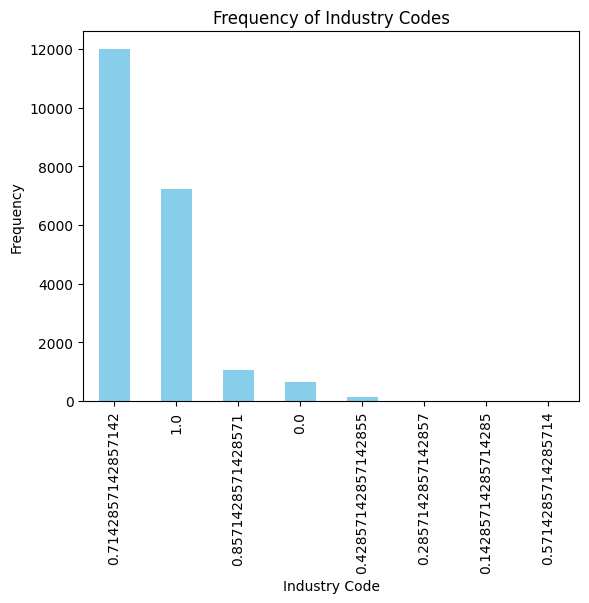

In [ ]:
industry_counts = df['c0039'].value_counts()
industry_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Industry Codes')
plt.xlabel('Industry Code')
plt.ylabel('Frequency')
plt.show()


#### This information could lead to creating weighted features that reflect the prevalence of industry codes, or to stratify analyses by industry if the industry is a strong predictor of the target variable.

### Modeling: solve the problem and compare several models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGMB
* Others

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(columns=['ap090', 'ct090'])
y = df['ct090']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()


}

# Training and getting the value of the model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {'Accuracy': accuracy, 'Classification Report': report}

# Showing the results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print(f"Accuracy: {result['Accuracy']}")
    print("------------------------------")


[LightGBM] [Info] Number of positive: 2622, number of negative: 14295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1962
[LightGBM] [Info] Number of data points in the train set: 16917, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154992 -> initscore=-1.695972
[LightGBM] [Info] Start training from score -1.695972
Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91      3554
         1.0       0.48      0.07      0.13       676

    accuracy                           0.84      4230
   macro avg       0.66      0.53      0.52      4230
weighted avg       0.79      0.84      0.79      4230

Accuracy: 0.8392434988179669
------------------------------
Model: Gradi